# GenVeg Main Script
## Test dune vegetation implementation
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new Landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file

### Define time controls

This sets up a one-year run with a daily timestep.

In [2]:
sim_start_date = np.datetime64('2010-01-01')
tot_sim_len_y = 30
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=365

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
VegInputFile = 'GenVeg_Dune_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file=Path(VegInputFile).absolute()
VegParams(fpath=inp_file,processes=['plantsize','dispersal','mortality'])
vegparams=load_params('veg_params.yml')
print(vegparams)

Not enough points to generate logistic function. Assuming zero mortality.
{'BTS': {'col_params': {'prob_colonization': 0.01, 'time_to_colonization': 365}, 'dispersal_params': {'max_dist_dispersal': 0.936, 'min_size_dispersal': 0.5, 'unit_cost_dispersal': 1.6025641025641024}, 'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'reproduction_start': 180, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': {'leaf': 1.463, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.513, 'storage': 1.415}, 'growth_max_biomass': 13.899999999999999, 'growth_min_biomass': 0.062222222222222213, 'k_light_extinct': 0.48, 'light_half_sat': 100, 'p_max': 0.05, 'plant_part_max': {'leaf': 5.5, 'reproductive': 1.5, 'root': 4.3, 'stem': 4.1, 'storage': 1}, 'plant_part_min': {'leaf': 0.03, 'reproductive': 0, 'root': 0.01, 'stem': 0.022222222222222223, 'storage': 0.01}, 'respiration_coefficient': {'leaf': 0.03, 'reproductive': 0.01, 'root': 0.015, 'stem': 0.015, 'storage': 0.01},

### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize live vegetation biomass and plant functional type
- Initialize the air temperature driver across the grid

##### **Note variable names should be consistent with landlab standards

In [5]:
#Create grid 10x10 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((6, 6), 2.0, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

#Create dummy datasets of mean monthly temperature, PAR, distance to the shore, and elevation relative to sea level
meantemp=[-0.20,  0.87,  4.40,  9.81,  15.36,  20.64,  23.86,  23.33, 19.95, 13.80,  7.85,  2.77, 11.93]
NJ_avg_par=[36.38, 52.39, 70.82, 92.88, 105.00, 116.38, 118.75, 103.21, 84.41, 59.15, 42.18, 31.98, 76.22]                
dist2shore=np.array([44,44,44,44,46,46,46,46,48,48,48,48,50,50,50,50])
rel_elev=np.array([0.4,0.4,0.4,0.4,0.6,0.6,0.6,0.6,0.9,0.9,0.9,0.9,1.2,1.2,1.2,1.2])

#Initialize with a dummy data sets 
_ = pg.add_field('air__temperature_C', meantemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__par_tot', NJ_avg_par[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')
_ = pg.add_field('Distance to shore', dist2shore, at='cell', units='m')
_ = pg.add_field('Minimum elevation', rel_elev, at='cell', units='m')

Now we initialize plants. We can do this in multiple ways. Here we are going to seed two species in a grid with 1/2 occupied by Ammophila, 1/2 by Spartina, at single and double planting densities, respectively.

Future iterations will rely on species boundaries and percent cover to initialize the plants.

In [6]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
_ = pg.add_field('vegetation__percent_cover', np.random.default_rng().uniform(low=0.0, high=0.2, size=pg.number_of_cells), at='cell', clobber=True)
plant_list=[['DB','null'],['DB','BTS'],['BTS','null']]
_ = pg.add_field('vegetation__plant_species',np.random.default_rng().choice(plant_list,pg.number_of_cells), at='cell', clobber=True)


In [7]:
pg['cell']['vegetation__percent_cover']

array([ 0.08673627,  0.03769583,  0.1728059 ,  0.1554974 ,  0.06217828,
        0.08307637,  0.06446568,  0.00039813,  0.14055423,  0.01521038,
        0.060321  ,  0.06147341,  0.18955852,  0.17408295,  0.01343523,
        0.05923992])

In [8]:
pg['cell']['vegetation__plant_species']

array([['DB', 'BTS'],
       ['DB', 'BTS'],
       ['DB', 'BTS'],
       ['DB', 'null'],
       ['DB', 'null'],
       ['DB', 'null'],
       ['DB', 'BTS'],
       ['DB', 'null'],
       ['DB', 'BTS'],
       ['DB', 'BTS'],
       ['DB', 'BTS'],
       ['DB', 'BTS'],
       ['DB', 'null'],
       ['BTS', 'null'],
       ['BTS', 'null'],
       ['DB', 'BTS']],
      dtype='<U4')

### Define model time variables

Initialize dune GenVeg class with veg_params from Excel file

In [9]:
foredune=GenVeg(pg,dt,sim_start_date,vegparams)

In [10]:
foredune.get_int_output()

[{'DB': 0.048520460688024881, 'BTS': 0.038215810721958871}, {'DB': 0.019542392742232316, 'BTS': 0.018153440638947003}, {'DB': 0.064449174205070944, 'BTS': 0.10835672875390205}, {'DB': 0.1554974026211858}, {'DB': 0.062178281963501038}, {'DB': 0.083076373033186629}, {'DB': 0.034257608626015568, 'BTS': 0.030208069751912408}, {'DB': 0.00039812648576365017}, {'DB': 0.075426324624133581, 'BTS': 0.06512790580514323}, {'DB': 0.0081749392993007187, 'BTS': 0.0070354450170358488}, {'DB': 0.024634496355886045, 'BTS': 0.035686505732358466}, {'DB': 0.029673065159264114, 'BTS': 0.031800340113573244}, {'DB': 0.18955851647542915}, {'BTS': 0.17408294535600238}, {'BTS': 0.013435234719537826}, {'DB': 0.025366357579023023, 'BTS': 0.033873558970599758}]


In [11]:
DB=pd.DataFrame(foredune.plant_species[1].species_plants())
BTS=pd.DataFrame(foredune.plant_species[0].species_plants())

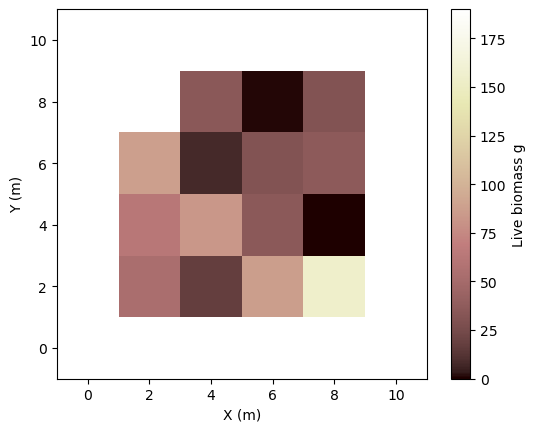

In [12]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Live biomass g')

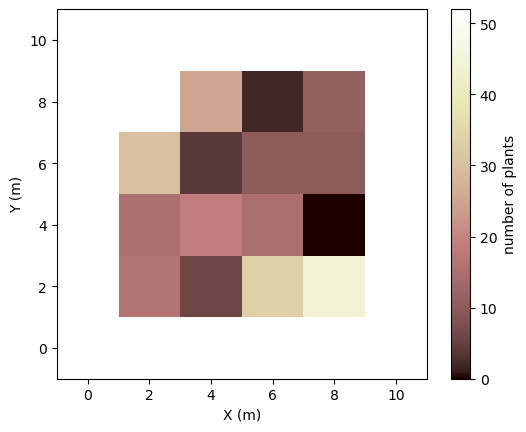

In [13]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

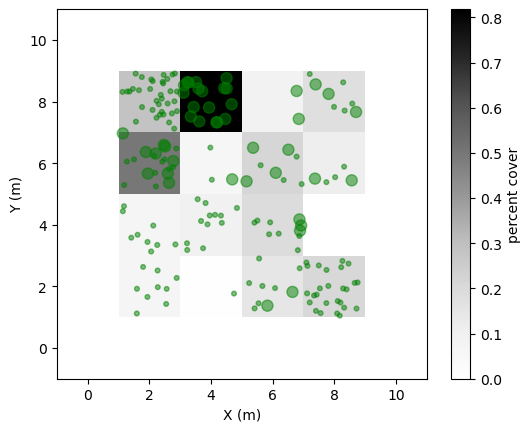

In [29]:
imshow_grid(pg, 'vegetation__percent_cover', at='cell', colorbar_label='percent cover', cmap='Greys')
ax=plt.gca()
end_data=pd.concat([DB,BTS], sort=False)
plant_locs=end_data[['x_loc','y_loc']].to_numpy()
sizes=end_data['root_sys_width'].values/2
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='green')
    ax.add_patch(circle)
plt.show()


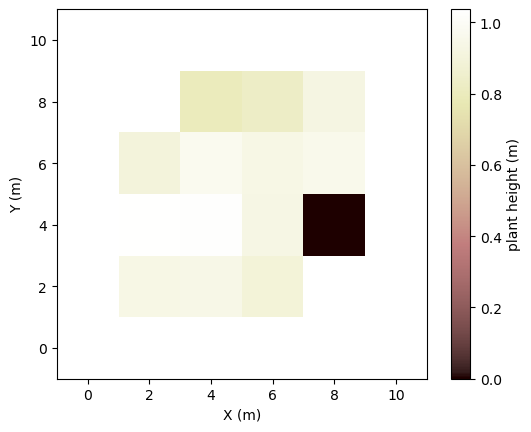

In [15]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

In [16]:
pd.DataFrame(foredune.plant_species[1].species_plants())

,species,pid,cell_index,x_loc,y_loc,root_biomass,leaf_biomass,stem_biomass,storage_biomass,repro_biomass,shoot_sys_width,root_sys_width,shoot_sys_height,root_sys_depth,plant_age,n_stems,pup_x_loc,pup_y_loc,pup_cost,item_id
0,DB,0,0,1.935426,1.654771,7.941238,0.0,0.0,0.632052,1.725968,0.0,0.282848,0.0,0.0,0.0,3,NaN,NaN,NaN,0
1,DB,1,0,2.271581,1.973223,6.040378,0.0,0.0,0.380073,2.088111,0.0,0.246101,0.0,0.0,0.0,3,NaN,NaN,NaN,1
2,DB,2,0,1.595474,1.920210,7.087330,0.0,0.0,0.797199,0.242049,0.0,0.272453,0.0,0.0,0.0,3,NaN,NaN,NaN,2
3,DB,3,0,2.769751,2.293976,1.055758,0.0,0.0,0.623208,2.087824,0.0,0.112102,0.0,0.0,0.0,4,NaN,NaN,NaN,3
4,DB,4,0,2.559737,1.917984,0.969855,0.0,0.0,0.101115,2.637078,0.0,0.113394,0.0,0.0,0.0,3,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,DB,195,15,7.994243,7.826106,1.949318,0.0,0.0,0.788863,2.198747,0.0,0.147128,0.0,0.0,0.0,2,NaN,NaN,NaN,195
196,DB,196,15,7.434271,8.868499,5.101144,0.0,0.0,0.652024,1.675909,0.0,0.223842,0.0,0.0,0.0,3,NaN,NaN,NaN,196
197,DB,197,15,8.585603,7.933012,8.384811,0.0,0.0,0.502472,0.493257,0.0,0.282172,0.0,0.0,0.0,3,NaN,NaN,NaN,197
198,DB,198,15,8.338157,7.705590,7.358901,0.0,0.0,0.812145,0.713696,0.0,0.272983,0.0,0.0,0.0,2,NaN,NaN,NaN,198


## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs

In [17]:
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
j=-1
for i in range(run_length_d):
    #update temp attribute on grid
    if (i/30).is_integer():
        pg.at_cell['air__temperature_C']= meantemp[j+1]*np.ones(pg.number_of_cells)
        pg.at_cell['radiation__par_tot']= NJ_avg_par[j+1]*np.ones(pg.number_of_cells)
        j+=1
    #update solar radiation on grid
    foredune.run_one_step()
    
    if (i/7).is_integer():
        foredune.save_output()
        write_netcdf("dune.nc",pg, format="NETCDF3_64BIT",append=True, time=(foredune.current_day-foredune.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants', 'vegetation__percent_cover'])


I emerge from dormancy
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing seas

In [18]:
output=foredune.get_plant_output()

grid = netcdf_file('crop.nc', 'r')
print(grid.__dict__)

timegrid=grid.variables['t']
timegrid[:]

vegbio=grid.variables['vegetation__total_biomass']
vegbio.shape

vegbio[10,:,:]

In [19]:
output.index.unique(level=2)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
           dtype='int64', name='item_id', length=200)

In [20]:
output.loc[:, 'BTS',11] #timestep,species,plant number in []

,grid_element,element_id,vegetation__root_biomass,vegetation__leaf_biomass,vegetation__stem_biomass,vegetation__storage_biomass,vegetation__repro_biomass,vegetation__plant_age
time,,,,,,,,
0.0,cell,2.0,1.081714,0.000000,0.000000,0.540110,0.589743,0.0
1.0,cell,2.0,1.081714,0.000000,0.000000,0.540110,0.589743,NaN
8.0,cell,2.0,1.070268,0.000000,0.000000,0.534395,0.583503,NaN
15.0,cell,2.0,1.058943,0.000000,0.000000,0.528740,0.577329,NaN
22.0,cell,2.0,1.047738,0.000000,0.000000,0.523145,0.571220,NaN
29.0,cell,2.0,1.036652,0.000000,0.000000,0.517610,0.565176,NaN
36.0,cell,2.0,1.024963,0.000000,0.000000,0.511773,0.558803,NaN
43.0,cell,2.0,1.013287,0.000000,0.000000,0.505943,0.552438,NaN
50.0,cell,2.0,1.001744,0.000000,0.000000,0.500180,0.546144,NaN


output.loc[21.0]

In [21]:
pd.set_option('display.max_rows',None)
DB=pd.DataFrame(foredune.plant_species[1].species_plants())
BTS=pd.DataFrame(foredune.plant_species[0].species_plants())
display(DB)
display(DB['x_loc'])

,species,pid,cell_index,x_loc,y_loc,root_biomass,leaf_biomass,stem_biomass,storage_biomass,repro_biomass,shoot_sys_width,root_sys_width,shoot_sys_height,root_sys_depth,plant_age,n_stems,pup_x_loc,pup_y_loc,pup_cost,item_id
0,DB,0,0,1.935426,1.654771,2.585248,2.559647,2.439897,5.675862e-06,0.000077,0.101836,0.152755,1.268075,0.0,0.0,3,NaN,NaN,NaN,0
1,DB,1,0,2.271581,1.973223,2.581457,2.556078,2.435857,3.358424e-06,0.000708,0.101738,0.152608,1.268850,0.0,0.0,3,NaN,NaN,NaN,1
2,DB,2,0,1.595474,1.920210,2.615891,2.590260,2.468131,7.218053e-06,0.350666,0.102592,0.153887,1.262159,0.0,0.0,3,NaN,NaN,NaN,2
3,DB,4,0,2.559737,1.917984,2.513348,2.491849,2.363558,1.320775e-08,0.000243,0.099965,0.149948,1.283184,0.0,0.0,3,NaN,NaN,NaN,4
4,DB,6,0,2.543226,1.427127,2.575540,2.550697,2.429071,6.458192e-06,0.038862,0.101582,0.152372,1.270095,0.0,0.0,2,NaN,NaN,NaN,6
5,DB,7,0,1.591075,1.118335,2.622362,2.596845,2.473788,8.360869e-06,0.455086,0.102748,0.154122,1.260946,0.0,0.0,6,NaN,NaN,NaN,7
6,DB,8,0,2.884822,2.271996,2.612716,2.586775,2.465994,6.924809e-07,0.248186,0.102520,0.153779,1.262718,0.0,0.0,3,NaN,NaN,NaN,8
7,DB,9,0,2.265786,2.514246,2.588659,2.565083,2.437960,4.031583e-06,0.450357,0.101882,0.152822,1.267719,0.0,0.0,2,NaN,NaN,NaN,9
8,DB,10,0,1.794433,2.630648,2.520609,2.498708,2.371236,4.199918e-08,0.001205,0.100155,0.150233,1.281619,0.0,0.0,4,NaN,NaN,NaN,10
9,DB,13,1,4.746239,1.764269,2.566854,2.543041,2.418511,4.968924e-06,0.142596,0.101346,0.152019,1.271970,0.0,0.0,2,NaN,NaN,NaN,13


0      1.935426
1      2.271581
2      1.595474
3      2.559737
4      2.543226
5      1.591075
6      2.884822
7      2.265786
8      1.794433
9      4.746239
10     6.878631
11     5.561991
12     6.079226
13     5.237845
14     5.413828
15     5.667957
16     5.543057
17     7.205180
18     7.129926
19     8.400169
20     8.322548
21     7.429655
22     8.093493
23     8.760041
24     7.096832
25     7.118494
26     7.407605
27     7.343995
28     7.749494
29     8.227870
30     8.464985
31     8.114740
32     7.744758
33     7.535058
34     8.665265
35     7.559566
36     8.723990
37     8.267071
38     8.288678
39     8.202005
40     7.808076
41     8.179788
42     7.498553
43     2.055797
44     2.843242
45     2.254524
46     1.174918
47     1.615962
48     2.124145
49     1.411648
50     1.137008
51     1.937997
52     3.566748
53     4.322023
54     4.350456
55     3.676985
56     3.959691
57     4.840859
58     3.227149
59     3.220514
60     3.822867
61     4.131166
62     3

In [22]:
biomass = output["vegetation__root_biomass"].values
display(biomass)


array([ 0.13542052,  2.39223656,  3.9203368 , ...,  2.62078388,
        2.6265137 ,  2.53105492])

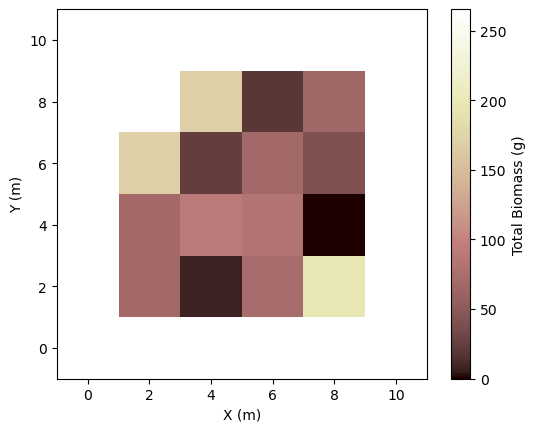

In [23]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)')

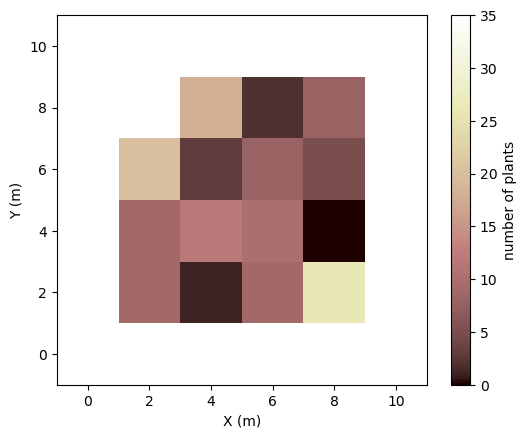

In [24]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

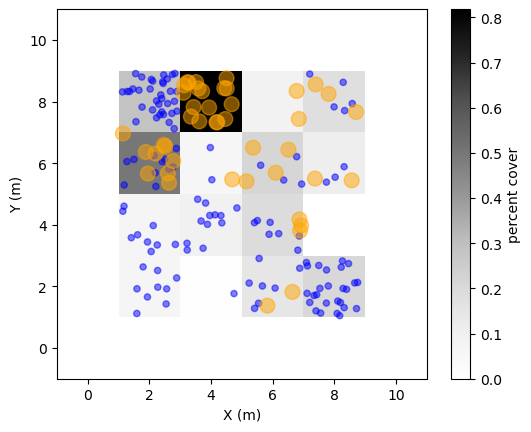

In [28]:
imshow_grid(pg, 'vegetation__percent_cover', at='cell', colorbar_label='percent cover', cmap='Greys')
ax=plt.gca()
end_data=pd.concat([DB,BTS], sort=False)
plant_locs=DB[['x_loc','y_loc']].to_numpy()
sizes=DB['shoot_sys_width'].values
   
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='blue')
    ax.add_patch(circle)
plant_locs=BTS[['x_loc','y_loc']].to_numpy()
sizes=BTS['shoot_sys_width'].values
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='orange')
    ax.add_patch(circle)
plt.show()

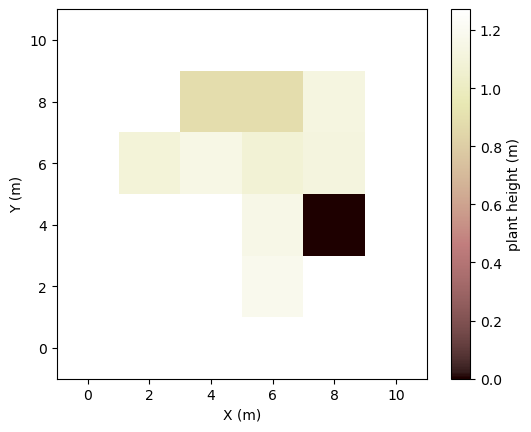

In [27]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

grid.close()